In [22]:
# Import dependencies
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
import sqlite3
# supervised model for labels

In [7]:
# Load the data

housing_df = pd.read_csv('ProjectTestData/housing_data_clean.csv')
crime_df = pd.read_csv('ProjectTestData/crime_count_data_clean.csv')
noise_df = pd.read_csv('ProjectTestData/Parcel_ExportTable_WithNoise_Cleaned.csv')

# conn = sqlite3.connect('housingSQL.db')
# query = "SELECT * FROM housing_table"
# homes_df = pd.read_sql_query(query, conn)
# conn.close()

# sql_query = pd.read_sql_query('''
#                               select * from DATAPORTFOLIO.dbo.WAKE_COUNTY_HOUSING_DATA
#                               '''
#                               ,conn) # here, the 'conn' is the variable that contains your database connection

# df = pd.DataFrame(sql_query)

housing_df.head()

# logistic is binary, k means is clusters (consumers based on income)

,TOTAL_VALUE,SITE_ADDRESS,CITY,ZIP_CODE,PLANNING_JURISDICTION,ZONING,ACREAGE,HEATED_AREA,AGE,BATH,REMODEL_ADDITION,STYLE
0,249321,2457 BERTIE DR,RALEIGH,27610,10,4.0,0.21,1828,59,2.0,0,8
1,159933,2848 PROVIDENCE RD,RALEIGH,27610,10,4.0,0.46,1240,53,1.0,0,0
2,222624,409 S LAKESIDE DR,RALEIGH,27606,10,4.0,0.43,1037,24,2.0,0,0
3,150723,540 MARSHBURN RD,WENDELL,27591,14,3.0,0.46,2261,123,2.0,0,0
4,140801,605 WOODLAND RD,RALEIGH,27603,6,2.0,0.51,996,67,1.0,0,0


In [15]:
housing_df

,TOTAL_VALUE,SITE_ADDRESS,CITY,ZIP_CODE,PLANNING_JURISDICTION,ZONING,ACREAGE,HEATED_AREA,AGE,BATH,REMODEL_ADDITION,STYLE
0,249321,2457 BERTIE DR,RALEIGH,27610,10,4.0,0.21,1828,59,2.0,0,8
1,159933,2848 PROVIDENCE RD,RALEIGH,27610,10,4.0,0.46,1240,53,1.0,0,0
2,222624,409 S LAKESIDE DR,RALEIGH,27606,10,4.0,0.43,1037,24,2.0,0,0
3,150723,540 MARSHBURN RD,WENDELL,27591,14,3.0,0.46,2261,123,2.0,0,0
4,140801,605 WOODLAND RD,RALEIGH,27603,6,2.0,0.51,996,67,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
185926,137044,6237 TEN TEN RD,APEX,27539,13,NaN,1.18,1456,36,2.0,0,13
185927,474932,500 KENT DR,CARY,27511,2,NaN,1.77,3110,26,2.5,0,0
185928,235612,1305 PONDEROSA DR,RALEIGH,27603,13,NaN,2.07,1640,61,2.0,0,0
185929,897806,1809 STILLWATER DR,RALEIGH,27607,10,4.0,0.34,3202,6,3.5,0,0


In [16]:
crime_df

,CITY,PERSONAL_CHARGE_COUNT,PERSONAL_NAME_COUNT,PROPERTY_CHARGE_COUNT,PROPERTY_NAME_COUNT,DRUG_CHARGE_COUNT,DRUG_NAME_COUNT,TOTAL_CHARGE_COUNT,TOTAL_NAME_COUNT
0,ANGIER,0,0,2,1,0,0,2,1
1,APEX,144,112,215,130,146,77,505,319
2,CARY,404,319,293,187,239,145,936,651
3,CLAYTON,11,6,9,4,7,4,27,14
4,CREEDMOOR,1,1,13,1,1,1,15,3
5,DURHAM,18,9,23,8,6,4,47,21
6,FUQUAY-VARINA,154,116,139,87,223,126,516,329
7,GARNER,259,202,441,286,285,171,985,659
8,HOLLY SPRINGS,111,88,205,110,272,133,588,331
9,KNIGHTDALE,109,83,143,95,95,54,347,232


In [17]:
noise_df

,TOTAL_VALUE,HEATED_AREA,SITE_ADDRESS,CITY,PLANNING_JURISDICTION,YEAR_BUILT,STYLE,ZIP_CODE,NOISE_CATEGORY,AIR_NOISE
0,485353,2987,408 CHANDLER GRANT DR,CARY,CA,2004,Conventional,27519,1,46.006540
1,381202,2453,105 LAKE BRANDT DR,CARY,CA,1997,Townhouse,27519,1,47.749096
2,297026,1641,135 WALTONS CREEK RD,MORRISVILLE,MO,1993,Conventional,27560,1,45.014290
3,270414,1267,139 WALTONS CREEK RD,MORRISVILLE,MO,1993,Conventional,27560,1,45.074585
4,876297,6318,207 KALVESTA DR,MORRISVILLE,MO,2001,Conventional,27560,1,46.160683
...,...,...,...,...,...,...,...,...,...,...
10913,407441,2705,6120 BLAKEMAN LN,RALEIGH,RA,2007,Conventional,27617,2,49.103012
10914,744169,1635,405 WATKINS RD,MORRISVILLE,MO,1970,Conventional,27560,3,53.249355
10915,533692,4139,104 PAXFORD CT,MORRISVILLE,MO,2004,Conventional,27560,2,51.026150
10916,263994,1075,802 CHURCH ST,MORRISVILLE,MO,1972,Conventional,27560,2,52.213262


In [10]:
# Check data types of all columns
housing_df.dtypes

TOTAL_VALUE                int64
SITE_ADDRESS              object
CITY                      object
ZIP_CODE                   int64
PLANNING_JURISDICTION      int64
ZONING                   float64
ACREAGE                  float64
HEATED_AREA                int64
AGE                        int64
BATH                     float64
REMODEL_ADDITION           int64
STYLE                      int64
dtype: object

In [11]:
crime_df.dtypes

CITY                     object
PERSONAL_CHARGE_COUNT     int64
PERSONAL_NAME_COUNT       int64
PROPERTY_CHARGE_COUNT     int64
PROPERTY_NAME_COUNT       int64
DRUG_CHARGE_COUNT         int64
DRUG_NAME_COUNT           int64
TOTAL_CHARGE_COUNT        int64
TOTAL_NAME_COUNT          int64
dtype: object

In [12]:
noise_df.dtypes

TOTAL_VALUE                int64
HEATED_AREA                int64
SITE_ADDRESS              object
CITY                      object
PLANNING_JURISDICTION     object
YEAR_BUILT                 int64
STYLE                     object
ZIP_CODE                  object
NOISE_CATEGORY             int64
AIR_NOISE                float64
dtype: object

In [13]:
# Joine housing data and crime data and keep all data on housing if missing joins from crime
house_crime_df = pd.merge(housing_df, crime_df, how="left", on=["CITY", "CITY"])
# Check database join
house_crime_df.head()

,TOTAL_VALUE,SITE_ADDRESS,CITY,ZIP_CODE,PLANNING_JURISDICTION,ZONING,ACREAGE,HEATED_AREA,AGE,BATH,REMODEL_ADDITION,STYLE,PERSONAL_CHARGE_COUNT,PERSONAL_NAME_COUNT,PROPERTY_CHARGE_COUNT,PROPERTY_NAME_COUNT,DRUG_CHARGE_COUNT,DRUG_NAME_COUNT,TOTAL_CHARGE_COUNT,TOTAL_NAME_COUNT
0,249321,2457 BERTIE DR,RALEIGH,27610,10,4.0,0.21,1828,59,2.0,0,8,4450.0,2945.0,5035.0,2634.0,3941.0,2042.0,13426.0,7621.0
1,159933,2848 PROVIDENCE RD,RALEIGH,27610,10,4.0,0.46,1240,53,1.0,0,0,4450.0,2945.0,5035.0,2634.0,3941.0,2042.0,13426.0,7621.0
2,222624,409 S LAKESIDE DR,RALEIGH,27606,10,4.0,0.43,1037,24,2.0,0,0,4450.0,2945.0,5035.0,2634.0,3941.0,2042.0,13426.0,7621.0
3,150723,540 MARSHBURN RD,WENDELL,27591,14,3.0,0.46,2261,123,2.0,0,0,69.0,49.0,68.0,42.0,61.0,29.0,198.0,120.0
4,140801,605 WOODLAND RD,RALEIGH,27603,6,2.0,0.51,996,67,1.0,0,0,4450.0,2945.0,5035.0,2634.0,3941.0,2042.0,13426.0,7621.0


In [14]:
# Check database join
house_crime_df

,TOTAL_VALUE,SITE_ADDRESS,CITY,ZIP_CODE,PLANNING_JURISDICTION,ZONING,ACREAGE,HEATED_AREA,AGE,BATH,REMODEL_ADDITION,STYLE,PERSONAL_CHARGE_COUNT,PERSONAL_NAME_COUNT,PROPERTY_CHARGE_COUNT,PROPERTY_NAME_COUNT,DRUG_CHARGE_COUNT,DRUG_NAME_COUNT,TOTAL_CHARGE_COUNT,TOTAL_NAME_COUNT
0,249321,2457 BERTIE DR,RALEIGH,27610,10,4.0,0.21,1828,59,2.0,0,8,4450.0,2945.0,5035.0,2634.0,3941.0,2042.0,13426.0,7621.0
1,159933,2848 PROVIDENCE RD,RALEIGH,27610,10,4.0,0.46,1240,53,1.0,0,0,4450.0,2945.0,5035.0,2634.0,3941.0,2042.0,13426.0,7621.0
2,222624,409 S LAKESIDE DR,RALEIGH,27606,10,4.0,0.43,1037,24,2.0,0,0,4450.0,2945.0,5035.0,2634.0,3941.0,2042.0,13426.0,7621.0
3,150723,540 MARSHBURN RD,WENDELL,27591,14,3.0,0.46,2261,123,2.0,0,0,69.0,49.0,68.0,42.0,61.0,29.0,198.0,120.0
4,140801,605 WOODLAND RD,RALEIGH,27603,6,2.0,0.51,996,67,1.0,0,0,4450.0,2945.0,5035.0,2634.0,3941.0,2042.0,13426.0,7621.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185926,137044,6237 TEN TEN RD,APEX,27539,13,NaN,1.18,1456,36,2.0,0,13,144.0,112.0,215.0,130.0,146.0,77.0,505.0,319.0
185927,474932,500 KENT DR,CARY,27511,2,NaN,1.77,3110,26,2.5,0,0,404.0,319.0,293.0,187.0,239.0,145.0,936.0,651.0
185928,235612,1305 PONDEROSA DR,RALEIGH,27603,13,NaN,2.07,1640,61,2.0,0,0,4450.0,2945.0,5035.0,2634.0,3941.0,2042.0,13426.0,7621.0
185929,897806,1809 STILLWATER DR,RALEIGH,27607,10,4.0,0.34,3202,6,3.5,0,0,4450.0,2945.0,5035.0,2634.0,3941.0,2042.0,13426.0,7621.0


In [18]:
# Joine housing/crime data and noise data and keep all data on housing if missing joins from noise
house_crime_noise_df = pd.merge(house_crime_df, noise_df, how="left", on=["SITE_ADDRESS", "SITE_ADDRESS"])
# Check database join
house_crime_noise_df.head()

,TOTAL_VALUE_x,SITE_ADDRESS,CITY_x,ZIP_CODE_x,PLANNING_JURISDICTION_x,ZONING,ACREAGE,HEATED_AREA_x,AGE,BATH,...,TOTAL_NAME_COUNT,TOTAL_VALUE_y,HEATED_AREA_y,CITY_y,PLANNING_JURISDICTION_y,YEAR_BUILT,STYLE_y,ZIP_CODE_y,NOISE_CATEGORY,AIR_NOISE
0,249321,2457 BERTIE DR,RALEIGH,27610,10,4.0,0.21,1828,59,2.0,...,7621.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,159933,2848 PROVIDENCE RD,RALEIGH,27610,10,4.0,0.46,1240,53,1.0,...,7621.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,222624,409 S LAKESIDE DR,RALEIGH,27606,10,4.0,0.43,1037,24,2.0,...,7621.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,150723,540 MARSHBURN RD,WENDELL,27591,14,3.0,0.46,2261,123,2.0,...,120.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,140801,605 WOODLAND RD,RALEIGH,27603,6,2.0,0.51,996,67,1.0,...,7621.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
house_crime_noise_df

,TOTAL_VALUE_x,SITE_ADDRESS,CITY_x,ZIP_CODE_x,PLANNING_JURISDICTION_x,ZONING,ACREAGE,HEATED_AREA_x,AGE,BATH,...,TOTAL_NAME_COUNT,TOTAL_VALUE_y,HEATED_AREA_y,CITY_y,PLANNING_JURISDICTION_y,YEAR_BUILT,STYLE_y,ZIP_CODE_y,NOISE_CATEGORY,AIR_NOISE
0,249321,2457 BERTIE DR,RALEIGH,27610,10,4.0,0.21,1828,59,2.0,...,7621.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,159933,2848 PROVIDENCE RD,RALEIGH,27610,10,4.0,0.46,1240,53,1.0,...,7621.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,222624,409 S LAKESIDE DR,RALEIGH,27606,10,4.0,0.43,1037,24,2.0,...,7621.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,150723,540 MARSHBURN RD,WENDELL,27591,14,3.0,0.46,2261,123,2.0,...,120.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,140801,605 WOODLAND RD,RALEIGH,27603,6,2.0,0.51,996,67,1.0,...,7621.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185926,137044,6237 TEN TEN RD,APEX,27539,13,NaN,1.18,1456,36,2.0,...,319.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
185927,474932,500 KENT DR,CARY,27511,2,NaN,1.77,3110,26,2.5,...,651.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
185928,235612,1305 PONDEROSA DR,RALEIGH,27603,13,NaN,2.07,1640,61,2.0,...,7621.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
185929,897806,1809 STILLWATER DR,RALEIGH,27607,10,4.0,0.34,3202,6,3.5,...,7621.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

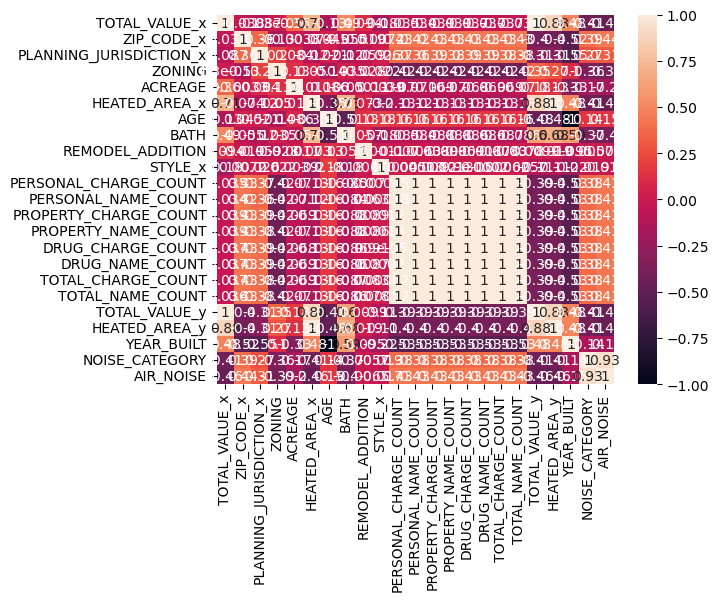

In [23]:
# https://stackoverflow.com/questions/39409866/correlation-heatmap
# Create a correlation heatmap to assess features for their significance
# load the R package ISLR
# infert = com.importr("ISLR")

# # load the Auto dataset
# df = com.load_data('Homes')

# # calculate the correlation matrix
# corr = df.corr()

# # plot the heatmap
# sns.heatmap(corr, 
#         xticklabels=corr.columns,
#         yticklabels=corr.columns)

Var_Corr = house_crime_noise_df.corr()
# plot the heatmap and annotation on it
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True)

In [29]:
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

Var_Corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,TOTAL_VALUE_x,ZIP_CODE_x,PLANNING_JURISDICTION_x,ZONING,ACREAGE,HEATED_AREA_x,AGE,BATH,REMODEL_ADDITION,STYLE_x,PERSONAL_CHARGE_COUNT,PERSONAL_NAME_COUNT,PROPERTY_CHARGE_COUNT,PROPERTY_NAME_COUNT,DRUG_CHARGE_COUNT,DRUG_NAME_COUNT,TOTAL_CHARGE_COUNT,TOTAL_NAME_COUNT,TOTAL_VALUE_y,HEATED_AREA_y,YEAR_BUILT,NOISE_CATEGORY,AIR_NOISE
TOTAL_VALUE_x,1.00,-0.04,-0.09,0.00,0.36,0.71,-0.13,0.49,0.09,-0.18,-0.03,-0.03,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,1.00,0.88,0.48,-0.41,-0.46
ZIP_CODE_x,-0.04,1.00,0.36,-0.13,-0.00,-0.07,0.04,-0.06,-0.02,0.01,0.43,0.42,0.43,0.43,0.43,0.43,0.43,0.43,-0.40,-0.40,-0.52,0.39,0.44
PLANNING_JURISDICTION_x,-0.09,0.36,1.00,0.20,0.08,-0.12,0.02,-0.12,-0.06,0.03,0.37,0.36,0.39,0.38,0.39,0.39,0.38,0.38,-0.31,-0.31,-0.55,0.27,0.31
ZONING,0.00,-0.13,0.20,1.00,0.13,0.05,-0.14,0.04,-0.03,0.02,-0.42,-0.42,-0.42,-0.42,-0.42,-0.42,-0.42,-0.42,0.35,0.27,0.10,-0.36,-0.39
ACREAGE,0.36,-0.00,0.08,0.13,1.00,0.01,0.09,-0.05,-0.00,0.00,-0.07,-0.07,-0.07,-0.07,-0.07,-0.07,-0.07,-0.07,0.18,0.13,-0.33,-0.17,-0.20
HEATED_AREA_x,0.71,-0.07,-0.12,0.05,0.01,1.00,-0.35,0.73,0.07,-0.20,-0.13,-0.12,-0.13,-0.13,-0.13,-0.13,-0.13,-0.13,0.88,1.00,0.48,-0.41,-0.46
AGE,-0.13,0.04,0.02,-0.14,0.09,-0.35,1.00,-0.51,0.13,0.18,0.16,0.16,0.16,0.16,0.16,0.16,0.16,0.16,-0.48,-0.48,-1.00,0.14,0.15
BATH,0.49,-0.06,-0.12,0.04,-0.05,0.73,-0.51,1.00,0.06,-0.18,-0.09,-0.08,-0.09,-0.09,-0.09,-0.09,-0.09,-0.09,0.60,0.68,0.59,-0.37,-0.40
REMODEL_ADDITION,0.09,-0.02,-0.06,-0.03,-0.00,0.07,0.13,0.06,1.00,0.00,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,0.01,0.02,-0.09,-0.01,-0.01
STYLE_x,-0.18,0.01,0.03,0.02,0.00,-0.20,0.18,-0.18,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.11,-0.11,-0.22,-0.02,-0.02


In [ ]:
# Select features we're interested in
features = ['HEATEDAREA', 'AIR_NOISE', 'TOTAL_CRIMES', 'POP_DENSITY', 'DESIGN_STYLE', 'YEAR_BUILT', 'ZIP_CODE', 'CITY']
X = homes_df[features]

In [ ]:
# 'TOTAL_VALUE' home cost is our target variable
y = df['TOTAL_VALUE']

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Create a Linear Regression model
home_value_model = LinearRegression()

In [ ]:
# Train the model
home_value_model.fit(X_train, y_train)

In [ ]:
# You can now use the model to make predictions, for example:
y_pred = home_value_model.predict(X_test)

In [2]:
# Add predictions to dataframe
homes_df['prediction'] = y_pred

In [ ]:
# Define your bins edges
bins = [0, 250000, 500000, float('inf')]

In [ ]:
# Define labels
value_labels = ['<250k', '250-500k', '>500k']

In [ ]:
# Create a new column with categorical labels
homes_df['price_range'] = pd.cut(homes_df['prediction'], bins=bins, labels=value_labels)